# Earthquake location

There are multiple ways to locate an earthquake, and multiple types of earthquake location.  We will mostly
consider hypocentre locations here, and we will extend that in the [final notebook](6_Source_Time_Functions.ipynb)
to think about whether a single location is a useful representation of an earthquake. A light introduction to
the theory behind eatrhquake location can be found in Section 7.2 of Stein and Wysession.

The hypocentre of an earthquake is the location that the earthquake starts (in contrast to the centroid location,
which is generally the centre of energy release of the earthquake). We can use the phase arrival picks we
made in the [picking notebook](2_Phase_Picking.ipynb) to constrain the hypocentre. We know from our
[ray-tracing](../2_Seismic_waves/2_Transmission.ipynb) that, if we know the velocity model, we can work
out how long it takes for a ray to travel from the earthquake source to our receiver.  If we have multiple
receivers then we can triangulate the location of the earthquake. However, to do that we also need to know
the origin time of the earthquake. When we think about solving for an earthquake location we need to remember
that we are finding the source in both space and time.

If we know the time of arrival of the P and S phases we can try and work out the distance from our receiver to
the source, but this assumes that the P and S waves follow the same ray-path.  Often the difference is small,
but real.

The way that we locate earthquakes using is to invert for the location. There are multiple schemes for how to
invert the data: we will just think about simple linearised inversion here, but those taking GPHS446 will see
other inversion methods. Linearised inversion works reasonably well for earthquakes that are not close to
the surface, are surrounded by receivers, and are within a smooth velocity structure.

In a simple homogeneous halfspace the arrival time of a given phase is given by simple trig:

\begin{equation*}
    t_i = T + \frac{\sqrt{(x - x_i)^2 + (y - y_i)^2 + (z - z_i)^2}}{v}
\end{equation*}

where subscript i denotes the $i^{th}$ station, x, y, z are the hypocentre co-ordinates, T is the origin time
and v is the waves velocity.

<img alt="Stein and Wysession Fig 7.2.1" align="centre" style="width:40%" src="http://levee.wustl.edu/seismology/book/chapter7/chap7_sr/7_2_01_s.jpg">

We will use this example of a 2D linear inversion to demonstrate the theory, then use the *hypocentre* linearised
location program to compute more thorough locations. However, there are many other ways to locate earthquakes, including
exhaustive grid searches or less exhaustive grid searches that sample only some of the model space. We can also
*relocate* earthquakes by refining their relative locations compared to other events (usually via double-difference methods).

## Introduction to inverse theory

\begin{equation*}
    d=Fm
\end{equation*}
where $d$ is the data (observations), $F$ is some function (a mathematical representation of the physics), and
$m$ is the model. In the case of earthquake location, $d$ is our observations of phase arrival times, 
$m$ is our model of the earthquake location and $F$ is our system of equations linking observations and model.

When we locate earthquakes we seek to minimize the error between what our modelled location predicts the arrival
times to be, and what we observe the arrival times to be.  We do not have perfect knowledge of the velocity
structure of the Earth, nor do we have perfect data (we have noise, so our pick-times will have some uncertainty),
so we are unlikely to get a perfect fit between our model and our data. In particular this leads to a system of
*inconsistent* equations. Our error is:

\begin{equation*}
    e_i = d^{obs}_i - d^{cal}_i
\end{equation*}

where $obs$ denotes our observations and $cal$ marks our caluclated arrival times. We need to have at least four
observations to have a well constrained system of equations (given our four unknowns of X, Y, Z and T). Commonly
we will have more than four observations which leads to an *overdetermined* system. To solve an *overdetermined* and
*inconsistent* set of equations there is no perfect model, instead we seek the *best* solution. To find the *best*
location we seek to minimize:

\begin{equation*}
    E = e^Te
\end{equation*}
which is the L2 norm. Other choices of norm are available and are made use of by different location methods.

To find the best fitting location we can either search through a series of forward-models (where some location
and origin time are set and the arrival times calculated), or iteratively search for the best model from
some starting model. Here we will consider the iterative method; this is more computationally efficient,
but is more succestible to finding local minima as solutions. In this approach have to make a *guess* at
the location and iteratively improve our model.  For local seismicity it is common to use a starting 
model close to the seismograph with the first arrival at some set depth.

To find the *best* solution we compute the partial derivatives of our system and move towards a minima in
error. However, in even the homogeneous half-space case, the equations are non-linear: the arrival time 
depends linearly on distance and origin-time, but not on hypocentral location. The way that we will 
solve this is to *linearize* the equation by taking the Taylor-series expansion and discarding all 
higher order terms. 

When we do this we find that the parital derivatives of the travel time are of the form:

\begin{equation*}
    \frac{\delta t}{\delta X} = \frac{(x - x_i)}{v\sqrt{(x - x_i)^2 + (y - y_i)^2 + (z - z_i)^2}}
\end{equation*}
with similar equations for $y$ and $z$.

These partial derivatives tell us the direction towards the next minima: we can compute the unit vector
pointing towards the minima as:
\begin{equation*}
    \nu = -\frac{\nabla E}{|\nabla E|}
\end{equation*}

## Implementation

I have written a simple, undamped linearised location program in Python in the `geiger_location.py` file.
We can call this and give it a go - it will produce plots of the location history.

To start with lets start with the perfectly determined case.

2019-05-13 22:02:06,265	Geiger	INFO	Starting model has residual of 3.18
2019-05-13 22:02:06,287	Geiger	INFO	Model updated to: (time 0.31, x 10.59, y 4.34 z 11.57)
2019-05-13 22:02:06,288	Geiger	INFO	Updated model has residual of 0.70
2019-05-13 22:02:06,289	Geiger	INFO	Model updated to: (time -0.00, x 10.02, y 4.00 z 12.02)
2019-05-13 22:02:06,290	Geiger	INFO	Updated model has residual of 0.01
2019-05-13 22:02:06,292	Geiger	INFO	Model updated to: (time 0.00, x 10.00, y 4.00 z 12.00)
2019-05-13 22:02:06,293	Geiger	INFO	Updated model has residual of 0.00
2019-05-13 22:02:06,294	Geiger	INFO	Model has reached convergence threshold


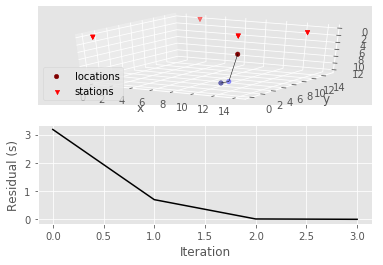

Found a solution at x = 10.00, y = 4.00, z = 12.00, time = 0.00


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import logging
logging.basicConfig(
    format="%(asctime)s\t%(name)s\t%(levelname)s\t%(message)s", 
    level=logging.INFO)
from geiger_inversion import geiger_locate

known_location = {"x": 10.0, "y": 4.0, "z": 12.0, "time": 0.0}
vp = 5.0
vs = 3.0

stations = [
    {"x": 0, "y": 0, "z": 0},
    {"x": 2, "y": 15, "z": 0},
    {"x": 10, "y": 7, "z": 0},
    {"x": 14, "y": 12, "z": 0}]

p_times = np.zeros(len(stations))
s_times = np.zeros_like(p_times)

for i, station in enumerate(stations):
    distance = (
        (station["x"] - known_location["x"]) ** 2 +
        (station["y"] - known_location["y"]) ** 2 + 
        (station["z"] - known_location["z"]) ** 2) ** 0.5
    p_times[i] = distance / vp
    s_times[i] = distance / vs

inverted_model = geiger_locate(
    p_times=p_times, p_locations=stations, s_times=s_times,
    s_locations=stations, vp=vp, vs=vs, starting_depth=5.0, plot=True)

print("Found a solution at x = {0:.2f}, y = {1:.2f}, z = {2:.2f}, "
      "time = {3:.2f}".format(inverted_model["x"], inverted_model["y"],
                              inverted_model["z"], inverted_model["time"]))

Lets try adding noise to the data.

2019-05-13 22:02:06,519	Geiger	INFO	Starting model has residual of 2.69
2019-05-13 22:02:06,521	Geiger	INFO	Model updated to: (time 0.16, x 11.88, y 2.43 z 11.46)
2019-05-13 22:02:06,521	Geiger	INFO	Updated model has residual of 1.10
2019-05-13 22:02:06,522	Geiger	INFO	Model updated to: (time -0.19, x 12.02, y 1.01 z 10.88)
2019-05-13 22:02:06,523	Geiger	INFO	Updated model has residual of 0.56
2019-05-13 22:02:06,524	Geiger	INFO	Model updated to: (time -0.19, x 12.04, y 1.00 z 10.76)
2019-05-13 22:02:06,525	Geiger	INFO	Updated model has residual of 0.56
2019-05-13 22:02:06,525	Geiger	INFO	Model updated to: (time -0.19, x 12.04, y 1.00 z 10.76)
2019-05-13 22:02:06,526	Geiger	INFO	Updated model has residual of 0.56
2019-05-13 22:02:06,526	Geiger	INFO	Model has reached convergence threshold


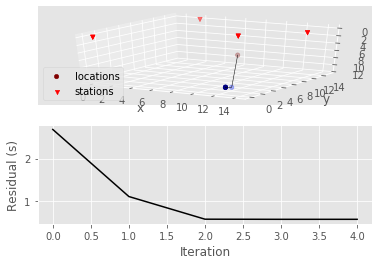

Solution at x = 12.04, y = 1.00, z = 10.76, time = -0.19


In [2]:
p_times = [time + np.random.sample() - .5 for time in p_times]
s_times = [time + np.random.sample() - .5 for time in s_times]

inverted_model = geiger_locate(
    p_times=p_times, p_locations=stations, s_times=s_times,
    s_locations=stations, vp=vp, vs=vs, starting_depth=5.0, plot=True)

print("Solution at x = {0:.2f}, y = {1:.2f}, z = {2:.2f}, "
      "time = {3:.2f}".format(inverted_model["x"], inverted_model["y"],
                              inverted_model["z"], inverted_model["time"]))

We don't get perfectly back to our initial location when we add noise in the range (-0.5, 0.5), unsurprisngly.

How about making it overdetermined?

2019-05-13 22:02:06,826	Geiger	INFO	Starting model has residual of 7.49
2019-05-13 22:02:06,828	Geiger	INFO	Model updated to: (time 0.30, x 9.48, y 3.97 z 11.49)
2019-05-13 22:02:06,830	Geiger	INFO	Updated model has residual of 1.57
2019-05-13 22:02:06,832	Geiger	INFO	Model updated to: (time 0.13, x 9.57, y 3.41 z 10.88)
2019-05-13 22:02:06,833	Geiger	INFO	Updated model has residual of 1.07
2019-05-13 22:02:06,835	Geiger	INFO	Model updated to: (time 0.13, x 9.57, y 3.41 z 10.86)
2019-05-13 22:02:06,837	Geiger	INFO	Updated model has residual of 1.07
2019-05-13 22:02:06,840	Geiger	INFO	Model updated to: (time 0.13, x 9.57, y 3.41 z 10.86)
2019-05-13 22:02:06,841	Geiger	INFO	Updated model has residual of 1.07
2019-05-13 22:02:06,843	Geiger	INFO	Model updated to: (time 0.13, x 9.57, y 3.41 z 10.86)
2019-05-13 22:02:06,844	Geiger	INFO	Updated model has residual of 1.07
2019-05-13 22:02:06,845	Geiger	INFO	Model updated to: (time 0.13, x 9.57, y 3.41 z 10.86)
2019-05-13 22:02:06,847	Geiger	IN

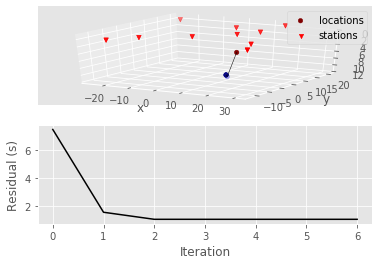

Found a solution at x = 9.57, y = 3.41, z = 10.86, time = 0.13


In [3]:
stations = [
    {"x": 0, "y": 0, "z": 0},
    {"x": 2, "y": 15, "z": 0},
    {"x": 10, "y": 7, "z": 0},
    {"x": 14, "y": 12, "z": 0},
    {"x": 20, "y": 2, "z": 1.2},
    {"x": 16, "y": 20, "z": -0.5},
    {"x": -20, "y": -12, "z": 0},
    {"x": -14, "y": -6, "z": 0},
    {"x": 30, "y": -10, "z": 0},
    {"x": -25, "y": 20, "z": 0}]

p_times = np.zeros(len(stations))
s_times = np.zeros_like(p_times)

for i, station in enumerate(stations):
    distance = (
        (station["x"] - known_location["x"]) ** 2 +
        (station["y"] - known_location["y"]) ** 2 + 
        (station["z"] - known_location["z"]) ** 2) ** 0.5
    p_times[i] = distance / vp
    s_times[i] = distance / vs

p_times = [time + np.random.sample() - .5 for time in p_times]
s_times = [time + np.random.sample() - .5 for time in s_times]
    
inverted_model = geiger_locate(
    p_times=p_times, p_locations=stations, s_times=s_times,
    s_locations=stations, vp=vp, vs=vs, convergence=0.00001, 
    starting_depth=5.0, plot=True)

print("Found a solution at x = {0:.2f}, y = {1:.2f}, z = {2:.2f}, "
      "time = {3:.2f}".format(inverted_model["x"], inverted_model["y"],
                              inverted_model["z"], inverted_model["time"]))

We don't get a much better location, but we are able to get close, despite the noise.


Lets try a real earthquake from GeoNet and see how well the simple model does.

2019-05-13 22:02:09,336	Geiger	INFO	Starting model has residual of 13.07
2019-05-13 22:02:09,337	Geiger	INFO	Model updated to: (time -2.32, x 10.26, y -5.13 z 15.35)
2019-05-13 22:02:09,338	Geiger	INFO	Updated model has residual of 2.94
2019-05-13 22:02:09,338	Geiger	INFO	Model updated to: (time -2.49, x 10.03, y -4.90 z 13.90)
2019-05-13 22:02:09,339	Geiger	INFO	Updated model has residual of 2.65
2019-05-13 22:02:09,340	Geiger	INFO	Model updated to: (time -2.48, x 10.04, y -4.92 z 13.59)
2019-05-13 22:02:09,341	Geiger	INFO	Updated model has residual of 2.65
2019-05-13 22:02:09,342	Geiger	INFO	Model updated to: (time -2.47, x 10.04, y -4.92 z 13.54)
2019-05-13 22:02:09,343	Geiger	INFO	Updated model has residual of 2.65
2019-05-13 22:02:09,343	Geiger	INFO	Model has reached convergence threshold


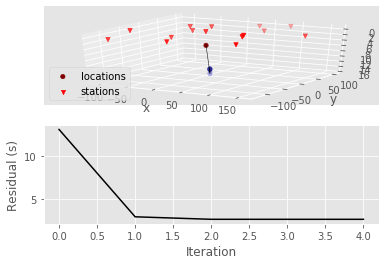

GeoNet location: -44.26753616 latitude, 169.3571014 longitude, 5.258625030999999 depth (km) 2019-05-08T20:03:32.781766Z origin time
Homogeneous model location: -44.274706 latitude, 169.359058 longitude, 13.878713 depth (km) 2019-05-08T20:03:33.353358Z origin time


In [4]:
from geiger_inversion import geiger_locate_lat_lon
from obspy.clients.fdsn import Client

client = Client("GEONET")
event = client.get_events(eventid="2019p345502")[0]
bulk = [
    (pick.waveform_id.network_code, pick.waveform_id.station_code,
     pick.waveform_id.location_code, pick.waveform_id.channel_code, 
     pick.time - 300, pick.time + 300) for pick in event.picks]
inventory = client.get_stations_bulk(bulk, level="channel")

p_times, p_locations, s_times, s_locations = ([], [], [], [])

for pick in event.picks:
    try:
        loc = inventory.get_coordinates(pick.waveform_id.get_seed_string())
    except:
        print("No location found for {0}".format(
            pick.waveform_id.get_seed_string()))
    if pick.phase_hint == "P":
        p_times.append(pick.time)
        p_locations.append(
            {"lat": loc["latitude"], "lon": loc["longitude"], 
             "z": loc["elevation"] / 1000.})
    elif pick.phase_hint == "S":
        s_times.append(pick.time)
        s_locations.append(
            {"lat": loc["latitude"], "lon": loc["longitude"], 
             "z": loc["elevation"] / 1000.})

model = geiger_locate_lat_lon(p_times, p_locations, s_times, s_locations, vp=6.0,
                              vs=3.6, plot=True, starting_depth=5.)

print("GeoNet location: {0} latitude, {1} longitude, {2} depth (km) {3} origin time".format(
    event.preferred_origin().latitude, event.preferred_origin().longitude,
    event.preferred_origin().depth / 1000., event.preferred_origin().time))
print("Homogeneous model location: {0} latitude, {1} longitude, {2} depth (km) {3} origin time".format(
    model["lat"], model["lon"], model["z"], model["time"]))

The homogeneous location is not very close to the GeoNet location. Think about why that might be? Hint: think about the
paths the rays are likely to have taken.

## Realistic velocity models

To incorporate more realistic velocity models all that is needed is to change how we calculate ray path 
distances. There are a range of ray-tracers available that find the shortest path between a given source
and reciever including the well cited [Moser 1991](https://library.seg.org/doi/pdf/10.1190/1.1442958).

There are multiple programs out there to compute earthquake locations in more realistic media, so we won't
reproduce them here. The principlces are the same, however, local minima become more of a problem
when velocity boundaries are included. This can show up as clusters of eatrhquakes locating at a
velocity boundary. To avoid this, different starting depths can be tested (e.g. start below and above the
boundary and compare the locations).

Some common earthquake location programs include:
- [hypoinverse](https://earthquake.usgs.gov/research/software/#HYPOINVERSE): linearised inversion
- [NonLinLoc](http://alomax.free.fr/nlloc/): 3D non-linear grid search inversion
- [HypoDD](https://earthquake.usgs.gov/research/software/#hypoDD): Double difference earthquake relocation
- [GrowClust](https://github.com/dttrugman/GrowClust): Double difference earthquake relocation for a modern era
- SIMUL